In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from erddapy import ERDDAP
import json
import re

Pull in the processed inventory

In [2]:
ra = "neracoos"

#
# df_cruise = df[df['Station Description'] == 'Chesapeake Bay WQ Cruise Data ']
#
#df_aws = df[df['Station ID'] == 'Humboldt']
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/OMOECC_E1/OMOECC_E1.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/45186/45186.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/bgsusd2/bgsusd2.ncml'
# url = 'http://oos.soest.hawaii.edu/thredds/dodsC/hioos/nss/ns12agg'
# print(url)
# ds = xr.open_dataset(url)
# #ds = netCDF4.Dataset(url,'r')
# title = ds.title
# start_time = np.datetime_as_string(ds.time.min().values, unit='D')
# end_time = np.datetime_as_string(ds.time.max().values, unit='D')
# print('Duration: %s - %s' % (np.datetime_as_string(ds.time.min().values, unit='D'),
#                              np.datetime_as_string(ds.time.max().values, unit='D'))
#       )

# Try glos web server
# url = 'https://glbuoys.glos.us/tools/export?ftype=csv&data_type=buoy&units=eng&locs=OMOECC_E1&params=Water_Temperature_at_Surface|dissolved_oxygen_saturation|water_conductivity|ysi_turbidity&tperiod=custom&date_start=2020-01-01&date_end=2020-12-31&avg_ivld=none'
# df = erddapy.ERDDAP.to_pandas(url)

## using ERDDAP to look for stations
# check out http://data.glos.us/erddap/tabledap/allDatasets.htmlTable?datasetID%2Ctitle%2CminTime%2CmaxTime&maxTime%3E=2020-01-01&maxTime%3C=2020-12-31&orderBy(%22maxTime%22)
# that lists out all the GLOS stations with the maximum time of observations within the year 2020 (on their ERDDAP).


ra_clean = re.sub(r'[0-9]', '', ra) # remove number from RA 

df = pd.read_excel('2024/data/processed/%s.xlsx' % ra_clean.upper(), dtype=str)
df.head()

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
0,NERACOOS,WHG,44090,Cape Cod Bay Wave Buoy,CDIP wave buoy,41.84,-70.329,wave_buoy,2016-05-23 00:00:00,Y,"NERACOOS, MassDEP",Yp,Woods Hole Group,industry,Woods Hole Group,"Woods Hole Group, CDIP, Gulf of Maine Research...","sea_water_temperature, sea_surface_wave_signif...",NaN
1,NERACOOS,WHG,44085,Buzzards Bay Wave Buoy,CDIP wave buoy,41.3871,-71.03,wave_buoy,2022-07-14 00:00:00,Y,"NERACOOS, MassDEP",Yp,Woods Hole Group,industry,Woods Hole Group,"Woods Hole Group, CDIP, Gulf of Maine Research...","sea_water_temperature, sea_surface_wave_signif...",NaN
2,NERACOOS,WHG,ca0101,"Cape Cod Canal, West End",NOAA currents station,41.84,-70.329,fixed,2019,Y,"NERACOOS, MassDEP",Yp,Woods Hole Group,industry,Woods Hole Group,"Woods Hole Group, NOAA CO-OPS, Gulf of Maine R...","sea_water_to_direction, sea_water_speed",per CO-OPS station data: H-ADCP mounted at a d...
3,NERACOOS,URI/GSO,NaN,Greenwich Bay,NBFSMN station,41.685,-71.446,fixed,6/1/2017 report to NERACOOS( 2003 historical),Y,NERACOOS (partial) URI/GSO (partial),Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...
4,NERACOOS,URI/GSO,NaN,GSO Dock,NBFSMN station,41.492,-71.419,fixed,6/1/2017 report to NERACOOS( 1995 historical),Y,NERACOOS (partial) URI/GSO (partial),Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",NaN


## Check column headers

The official column headers are found in the README at https://github.com/ioos/ioos-asset-inventory/tree/main. This checks the column headers from the RA inventory against our official column headers to see if anything is missing. The result will print out what columns are missing from the RA inventory and what columns the RA added to their inventory.

In [3]:
url = 'https://github.com/ioos/ioos-asset-inventory/tree/main'

import pandas as pd

df_fields = pd.read_html(url)#

control_fields = df_fields[2]['Field'].tolist()


def diff(a, b):
  if len(set(a) - set(b)) > 0:
    print(f"Columns missing: {set(a) - set(b)}")
  if len(set(b) - set(a)) > 0:
    print(f"Columns added: {set(b) - set(a)}")
  if set(a) == set(b):
    print(f"They are the same")

diff(control_fields, df.columns.tolist())

They are the same


Make a plot of all points.

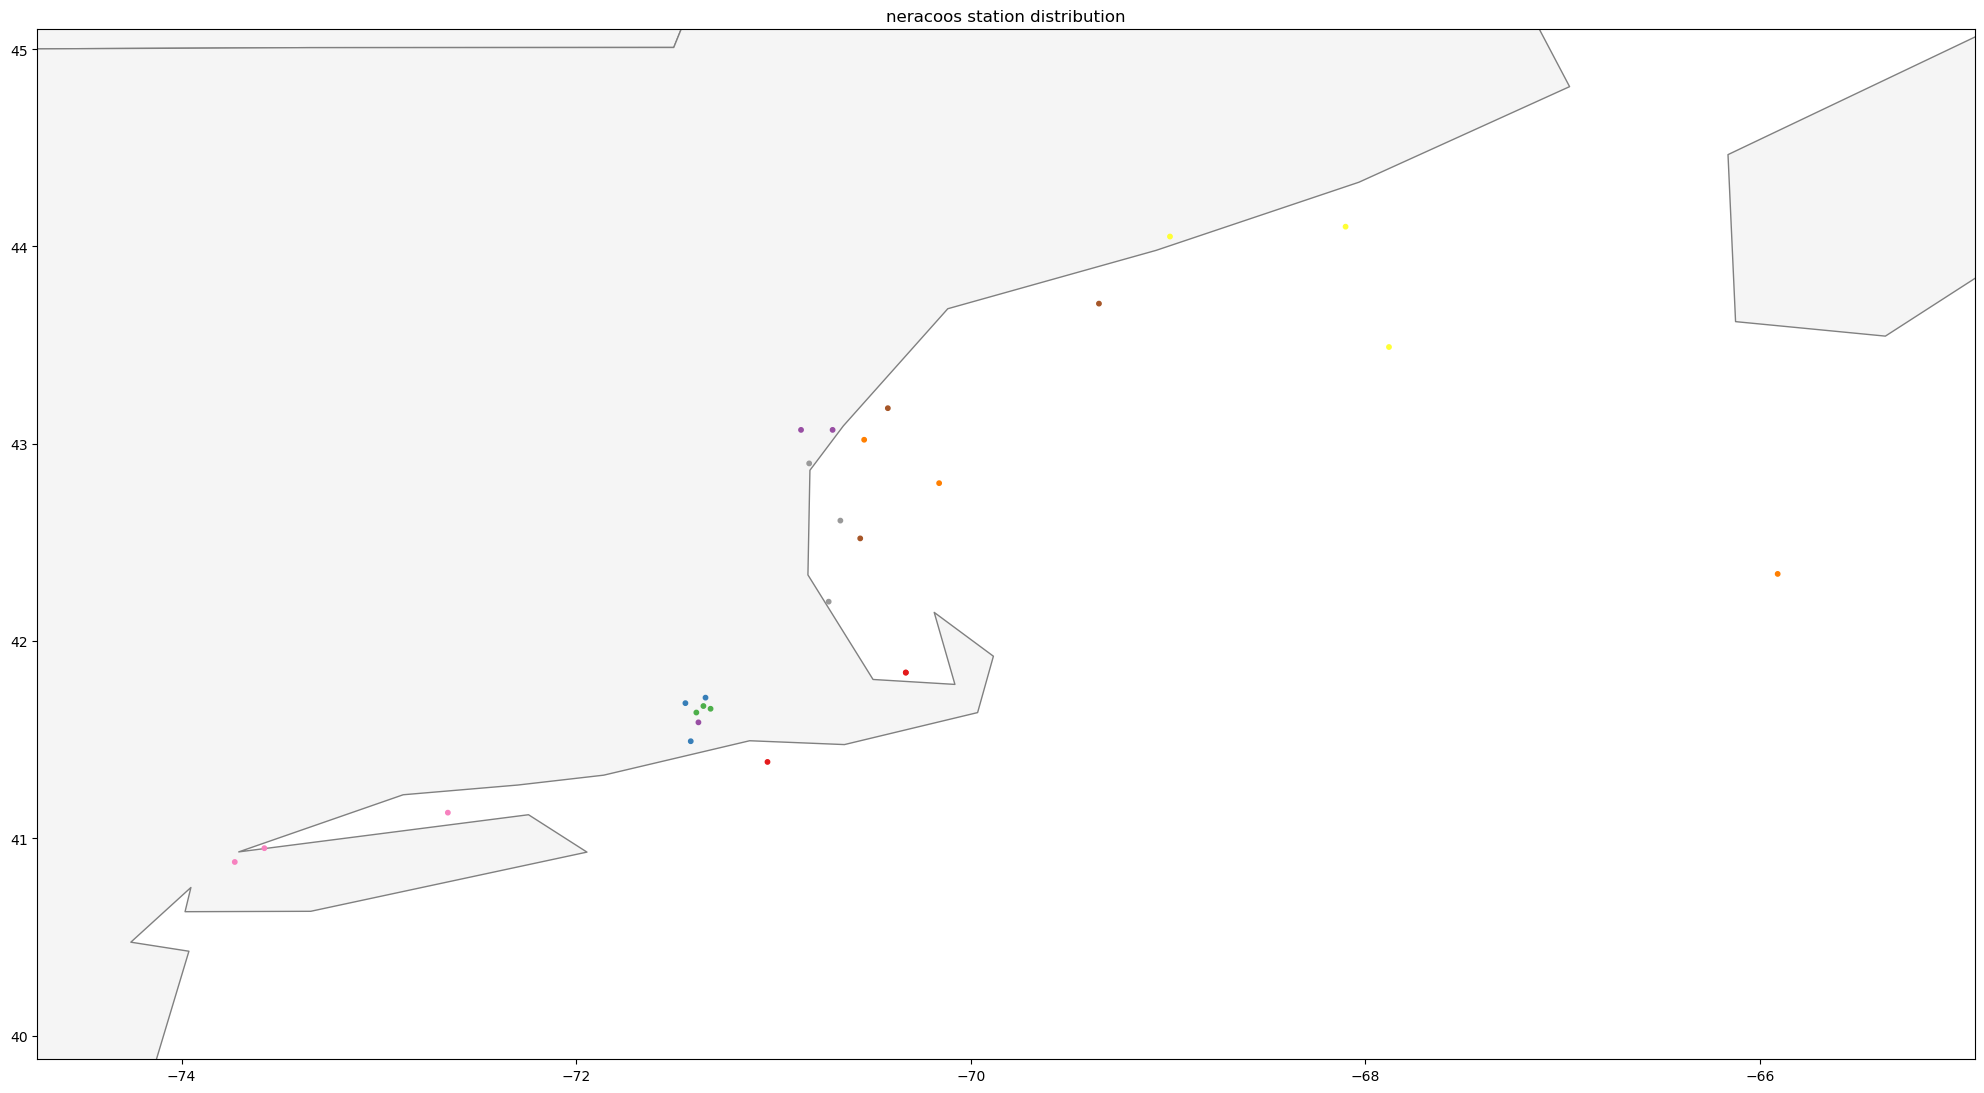

In [4]:
import geopandas
import matplotlib.pyplot as plt

#df = df.loc[df['']]

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='whitesmoke', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         #column='erddap_avail', 
         categorical=True, 
         cmap = 'Set1',
         markersize=10, 
         legend=True,
         legend_kwds={'title': "ERDDAP Available?"},
         k=2,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)

plt.title('{} station distribution'.format(ra))

plt.show()

Make an interactive map.

When you click on a point the return is the information from the inventory.

In [5]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.loc[~gdf_final['geometry'].is_empty == True].drop(columns='Variable Names').explore()#'erddap_avail',cmap = 'Set1')


Configure the ERDDAP to search

In [6]:
with open('utils/ra_erddaps.json') as f:
    urls = json.load(f)

server = urls[ra.lower()]

print(server)

e = ERDDAP(server=server, protocol="tabledap")

https://data.neracoos.org/erddap


Search the ERDDAP server for a single station of interest - more of a test

In [7]:
# df['Station ID'].loc[df['Station ID'].isna()] = df.loc[df['Station ID'].isna(),'Dataset ID']

# df['Station ID']

In [8]:
# df_wf = df[df['Station ID'] == 'Jug_Bay']

# # for SCCOOS need to search for 'Station Long Name' as 'Station ID' is NA for most entries
# search_for = df_wf['Station ID'].to_string()

# search_url = e.get_search_url(search_for=search_for, response="csv")

# try:
#     resp = pd.read_csv(search_url)
#     print(resp['Station ID'])
# except:
#     pass

Rip through all the datasets in the inventory and see if they exist on the RA erddap. Process checks the following order:

1. `Station ID`, then 
2. `Station Long Name`, then
3. `WMO ID or NWS/CMAN ID`

We first check if the value is `nan`. If so, we punt as that will return all datasets from the ERDDAP service.

In [9]:
not_found = []
found = dict()

exclude = ' -gliders'


if ra == 'glos':
    search_order = ['Dataset (ERDDAP) ID','Station ID', 'Station Long Name']
elif ra == 'sccoos':
    search_order = ['Station Long Name', 'WMO ID or NWS/CMAN ID', 'Station Description']
else:
    search_order = ['Station ID', 'Station Long Name', 'WMO ID or NWS/CMAN ID']

for search1 in df[search_order[0]].astype(str):

    if search1 == "nan":
        print("punting with %s = nan\n" % search_order[0])
        not_found.append(search1)
        continue
    
    try:
        print('searching \"%s\" = \"%s\"' % (search_order[0], search1))
        search_url = e.get_search_url(search_for=search1+exclude, response="csv")
        resp = pd.read_csv(search_url)
        
        print("Found \"%s\": %s" % (search1,resp['Dataset ID'].values.tolist()))
        
        for dset_id in resp['Dataset ID'].values.tolist():
            if search1.lower() in dset_id.lower():
                found[search1] = {'Dataset ID': [dset_id]}
                print("Keeping \"%s\": %s" % (search1,dset_id))
                #found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
        
    except:
        
        print('no dataset matching \"%s\"' % search1)
        search2 = df.loc[df[search_order[0]] == search1, search_order[1]].values.tolist()[0]
        
        if search2 == "nan":
                print("punting with %s = nan\n" % search_order[1])
                not_found.append(search1)
                continue
                
        try:
            
            print('searching \"%s\" = \"%s\"' % (search_order[1], search2))
            search_url = e.get_search_url(search_for=search2+exclude, response="csv")
            resp = pd.read_csv(search_url)
            print("Found \"%s\": %s" % (search2,resp['Dataset ID'].values.tolist()))
            
            found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
            
        except:

            search3 = str(df.loc[df[search_order[0]] == search1, search_order[2]].values.tolist()[0])
            
            if search3 == "nan":
                print("punting with \"%s\" = nan\n" % search_order[2])
                not_found.append(search1)
                continue
            
            try:
                print('searching \"%s\" = \"%s\"' % (search_order[2], search3))
                search_url = e.get_search_url(search_for=search3+exclude, response="csv")
                resp = pd.read_csv(search_url)
                print("Found \"%s\": %s" % (search3,resp['Dataset ID'].values.tolist()))
                
                found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
                
            except:
                print("Couldn't find:", [search1, search2, search3])
                not_found.append(search1)
        
    print("\n")

searching "Station ID" = "WHG"


no dataset matching "WHG"
searching "Station Long Name" = "Cape Cod Bay Wave Buoy"
searching "WMO ID or NWS/CMAN ID" = "44090"
Found "44090": ['NDBC_44090']


searching "Station ID" = "WHG"
no dataset matching "WHG"
searching "Station Long Name" = "Cape Cod Bay Wave Buoy"
searching "WMO ID or NWS/CMAN ID" = "44090"
Found "44090": ['NDBC_44090']


searching "Station ID" = "WHG"
no dataset matching "WHG"
searching "Station Long Name" = "Cape Cod Bay Wave Buoy"
searching "WMO ID or NWS/CMAN ID" = "44090"
Found "44090": ['NDBC_44090']


searching "Station ID" = "URI/GSO"
no dataset matching "URI/GSO"
searching "Station Long Name" = "Greenwich Bay"
punting with "WMO ID or NWS/CMAN ID" = nan

searching "Station ID" = "URI/GSO"
no dataset matching "URI/GSO"
searching "Station Long Name" = "Greenwich Bay"
punting with "WMO ID or NWS/CMAN ID" = nan

searching "Station ID" = "URI/GSO"
no dataset matching "URI/GSO"
searching "Station Long Name" = "Greenwich Bay"
punting with "WMO ID or NWS/CMAN I

Print the stations that we couldn't find.

In [10]:
len(not_found)

11

In [11]:
len(found)

4

Show me the record that has NaN for the first search element.

In [12]:
df.loc[df[search_order[0]].isna()]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry


Now show me the stations, with identifiers, that we couldn't find.

In [13]:
df[df[search_order[0]].isin(not_found)]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry
3,NERACOOS,URI/GSO,NaN,Greenwich Bay,NBFSMN station,41.685,-71.446,fixed,6/1/2017 report to NERACOOS( 2003 historical),Y,NERACOOS (partial) URI/GSO (partial),Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.44600 41.68500)
4,NERACOOS,URI/GSO,NaN,GSO Dock,NBFSMN station,41.492,-71.419,fixed,6/1/2017 report to NERACOOS( 1995 historical),Y,NERACOOS (partial) URI/GSO (partial),Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",NaN,POINT (-71.41900 41.49200)
5,NERACOOS,URI/GSO,NaN,Conimicut Pt,NBFSMN station,41.7129,-71.34411667,moored_buoy,6/1/2019 report to NERACOOS( 2003 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.34412 41.71290)
6,NERACOOS,URI/GSO,NaN,North Prudence,NBFSMN station,41.6704,-71.354716,moored_buoy,6/1/2019 report to NERACOOS( 2001 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.35472 41.67040)
7,NERACOOS,URI/GSO,NaN,Poppasquash Pt,NBFSMN station,41.65655,-71.3185,moored_buoy,6/1/2019 report to NERACOOS( 2005 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.31850 41.65655)
8,NERACOOS,URI/GSO,NaN,Mt View,NBFSMN station,41.637466,-71.390566,moored_buoy,6/1/2006 report to NERACOOS ( 2005 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.39057 41.63747)
9,NERACOOS,URI/GSO,NaN,Quonset Pt,NBFSMN station,41.58761667,-71.38003333,moored_buoy,6/1/2006 report to NERACOOS ( 2005 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.38003 41.58762)
21,NERACOOS,UCONN,44022,Execution Rocks,Moored buoy.,40.88,-73.73,moored_buoy,2004-09-01 00:00:00,Y,NERACOOS,Yp,University of Connecticut,academic,University of Connecticut,"University of Connecticut, Gulf of Maine Resea...","wind_speed, wind_to_direction, barometric_alti...",NaN,POINT (-73.73000 40.88000)
22,NERACOOS,UCONN,44040,Western Long Island Sound,Moored buoy.,40.95,-73.58,moored_buoy,2001-08-01 00:00:00,Y,NERACOOS,Yp,University of Connecticut,academic,University of Connecticut,"University of Connecticut, Gulf of Maine Resea...","wind_speed, wind_to_direction, barometric_alti...",NaN,POINT (-73.58000 40.95000)
23,NERACOOS,UCONN,44039,Central Long Island Sound,Moored buoy.,41.13,-72.65,moored_buoy,2002-02-01 00:00:00,Y,NERACOOS,Yp,University of Connecticut,academic,University of Connecticut,"University of Connecticut, Gulf of Maine Resea...","wind_speed, wind_to_direction, barometric_alti...",NaN,POINT (-72.65000 41.13000)


Print out all the dataset IDs for the datasets that matched our criteria.

In [14]:
found

{'WHG': {'Dataset ID': ['NDBC_44090']},
 'UNH': {'Dataset ID': ['UNH_SPOT_1469']},
 'CG/SCI-01': {'Dataset ID': ['ONSET_scituate_hourly_water_level']},
 'CG/HAM-01': {'Dataset ID': ['ONSET_hamptonbay_hourly_water_level']}}

Check if each found dataset has coverage for specified CY

In [15]:
valid_datasets = []

cy = '2024'
n=0
for key in found:
    
    print(f'testing {key}')
    
    dataset_id = found[key]['Dataset ID'] #+" "+found[key]['Station ID']
    
    if (len(dataset_id)>1):
        
        for dataset in dataset_id:
            n+=1
            if (n<3):
                e.dataset_id = dataset
        
                e.constraints = {
                    "time>=": "{}-01-01".format(cy)
                }
            
                e.variables = ['time']
        
                try:
                    df_data = e.to_pandas(parse_dates=True)
                    valid_datasets.extend([key])
                    
                except:

                    print(f'No data for {cy} for {key}: dataset ID {e.dataset_id}')# % (key,e.dataset_id))

                    pass

                

    else:
        
        e.dataset_id = dataset_id[0]
    
        e.constraints = {
                         "time>=": "{}-01-01".format(cy)
                        }
        
        e.variables = ['time']
        
        try:
            
            df_data = e.to_pandas(parse_dates=True)

            valid_datasets.extend([key])

        except:

            print(f'No data for {cy} for {key}: dataset ID {e.dataset_id}')# % (key,e.dataset_id))
            
            pass

            #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

            
#for valid in sorted(set(valid_datasets)):
    
#     # drop qc vars
#     cols = [c for c in df_data.columns if 'qc' not in c]
#     cols = [c for c in cols if 'QARTOD' not in c]

#     df_data = df_data[cols]

#     # set index for plotting
#     df_data = df_data.set_index(df_data['time (UTC)'])

#     # plot
#     #df_data.plot(subplots=True, title=e.dataset_id,figsize=(20,20))

#     start_time = df_data['time (UTC)'].min()
#     end_time = df_data['time (UTC)'].max()

#     print('Dataset %s' % e.dataset_id)
#     print('Duration: %s - %s' % (start_time, end_time))

no_cov_datasets = found.keys() - sorted(set(valid_datasets))

print('Datasets without coverage for {}:\n{}'.format(cy,no_cov_datasets))

testing WHG


testing UNH
testing CG/SCI-01
testing CG/HAM-01
Datasets without coverage for 2024:
set()


Show me the inventory metadata about the invalid stations:

In [16]:
bad_stations = df.loc[(df[search_order[0]].isin(no_cov_datasets)) | df[search_order[0]].isin(not_found)]

df['erddap_not_avail'] = df[search_order[0]].isin(bad_stations[search_order[0]])

df.loc[df['erddap_not_avail']]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_not_avail
3,NERACOOS,URI/GSO,NaN,Greenwich Bay,NBFSMN station,41.685,-71.446,fixed,6/1/2017 report to NERACOOS( 2003 historical),Y,NERACOOS (partial) URI/GSO (partial),Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.44600 41.68500),True
4,NERACOOS,URI/GSO,NaN,GSO Dock,NBFSMN station,41.492,-71.419,fixed,6/1/2017 report to NERACOOS( 1995 historical),Y,NERACOOS (partial) URI/GSO (partial),Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",NaN,POINT (-71.41900 41.49200),True
5,NERACOOS,URI/GSO,NaN,Conimicut Pt,NBFSMN station,41.7129,-71.34411667,moored_buoy,6/1/2019 report to NERACOOS( 2003 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.34412 41.71290),True
6,NERACOOS,URI/GSO,NaN,North Prudence,NBFSMN station,41.6704,-71.354716,moored_buoy,6/1/2019 report to NERACOOS( 2001 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.35472 41.67040),True
7,NERACOOS,URI/GSO,NaN,Poppasquash Pt,NBFSMN station,41.65655,-71.3185,moored_buoy,6/1/2019 report to NERACOOS( 2005 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.31850 41.65655),True
8,NERACOOS,URI/GSO,NaN,Mt View,NBFSMN station,41.637466,-71.390566,moored_buoy,6/1/2006 report to NERACOOS ( 2005 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.39057 41.63747),True
9,NERACOOS,URI/GSO,NaN,Quonset Pt,NBFSMN station,41.58761667,-71.38003333,moored_buoy,6/1/2006 report to NERACOOS ( 2005 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.38003 41.58762),True
21,NERACOOS,UCONN,44022,Execution Rocks,Moored buoy.,40.88,-73.73,moored_buoy,2004-09-01 00:00:00,Y,NERACOOS,Yp,University of Connecticut,academic,University of Connecticut,"University of Connecticut, Gulf of Maine Resea...","wind_speed, wind_to_direction, barometric_alti...",NaN,POINT (-73.73000 40.88000),True
22,NERACOOS,UCONN,44040,Western Long Island Sound,Moored buoy.,40.95,-73.58,moored_buoy,2001-08-01 00:00:00,Y,NERACOOS,Yp,University of Connecticut,academic,University of Connecticut,"University of Connecticut, Gulf of Maine Resea...","wind_speed, wind_to_direction, barometric_alti...",NaN,POINT (-73.58000 40.95000),True
23,NERACOOS,UCONN,44039,Central Long Island Sound,Moored buoy.,41.13,-72.65,moored_buoy,2002-02-01 00:00:00,Y,NERACOOS,Yp,University of Connecticut,academic,University of Connecticut,"University of Connecticut, Gulf of Maine Resea...","wind_speed, wind_to_direction, barometric_alti...",NaN,POINT (-72.65000 41.13000),True


Invert the `erddap_not_avail` column and drop it.

In [17]:
df['erddap_avail'] = ~df['erddap_not_avail']

df.drop(columns='erddap_not_avail', inplace=True)

df

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_avail
0,NERACOOS,WHG,44090,Cape Cod Bay Wave Buoy,CDIP wave buoy,41.84,-70.329,wave_buoy,2016-05-23 00:00:00,Y,"NERACOOS, MassDEP",Yp,Woods Hole Group,industry,Woods Hole Group,"Woods Hole Group, CDIP, Gulf of Maine Research...","sea_water_temperature, sea_surface_wave_signif...",NaN,POINT (-70.32900 41.84000),True
1,NERACOOS,WHG,44085,Buzzards Bay Wave Buoy,CDIP wave buoy,41.3871,-71.03,wave_buoy,2022-07-14 00:00:00,Y,"NERACOOS, MassDEP",Yp,Woods Hole Group,industry,Woods Hole Group,"Woods Hole Group, CDIP, Gulf of Maine Research...","sea_water_temperature, sea_surface_wave_signif...",NaN,POINT (-71.03000 41.38710),True
2,NERACOOS,WHG,ca0101,"Cape Cod Canal, West End",NOAA currents station,41.84,-70.329,fixed,2019,Y,"NERACOOS, MassDEP",Yp,Woods Hole Group,industry,Woods Hole Group,"Woods Hole Group, NOAA CO-OPS, Gulf of Maine R...","sea_water_to_direction, sea_water_speed",per CO-OPS station data: H-ADCP mounted at a d...,POINT (-70.32900 41.84000),True
3,NERACOOS,URI/GSO,NaN,Greenwich Bay,NBFSMN station,41.685,-71.446,fixed,6/1/2017 report to NERACOOS( 2003 historical),Y,NERACOOS (partial) URI/GSO (partial),Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.44600 41.68500),False
4,NERACOOS,URI/GSO,NaN,GSO Dock,NBFSMN station,41.492,-71.419,fixed,6/1/2017 report to NERACOOS( 1995 historical),Y,NERACOOS (partial) URI/GSO (partial),Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",NaN,POINT (-71.41900 41.49200),False
5,NERACOOS,URI/GSO,NaN,Conimicut Pt,NBFSMN station,41.7129,-71.34411667,moored_buoy,6/1/2019 report to NERACOOS( 2003 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.34412 41.71290),False
6,NERACOOS,URI/GSO,NaN,North Prudence,NBFSMN station,41.6704,-71.354716,moored_buoy,6/1/2019 report to NERACOOS( 2001 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.35472 41.67040),False
7,NERACOOS,URI/GSO,NaN,Poppasquash Pt,NBFSMN station,41.65655,-71.3185,moored_buoy,6/1/2019 report to NERACOOS( 2005 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.31850 41.65655),False
8,NERACOOS,URI/GSO,NaN,Mt View,NBFSMN station,41.637466,-71.390566,moored_buoy,6/1/2006 report to NERACOOS ( 2005 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.39057 41.63747),False
9,NERACOOS,URI/GSO,NaN,Quonset Pt,NBFSMN station,41.58761667,-71.38003333,moored_buoy,6/1/2006 report to NERACOOS ( 2005 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.38003 41.58762),False


Make a plot of all points and color based on ERDDAP available or not.

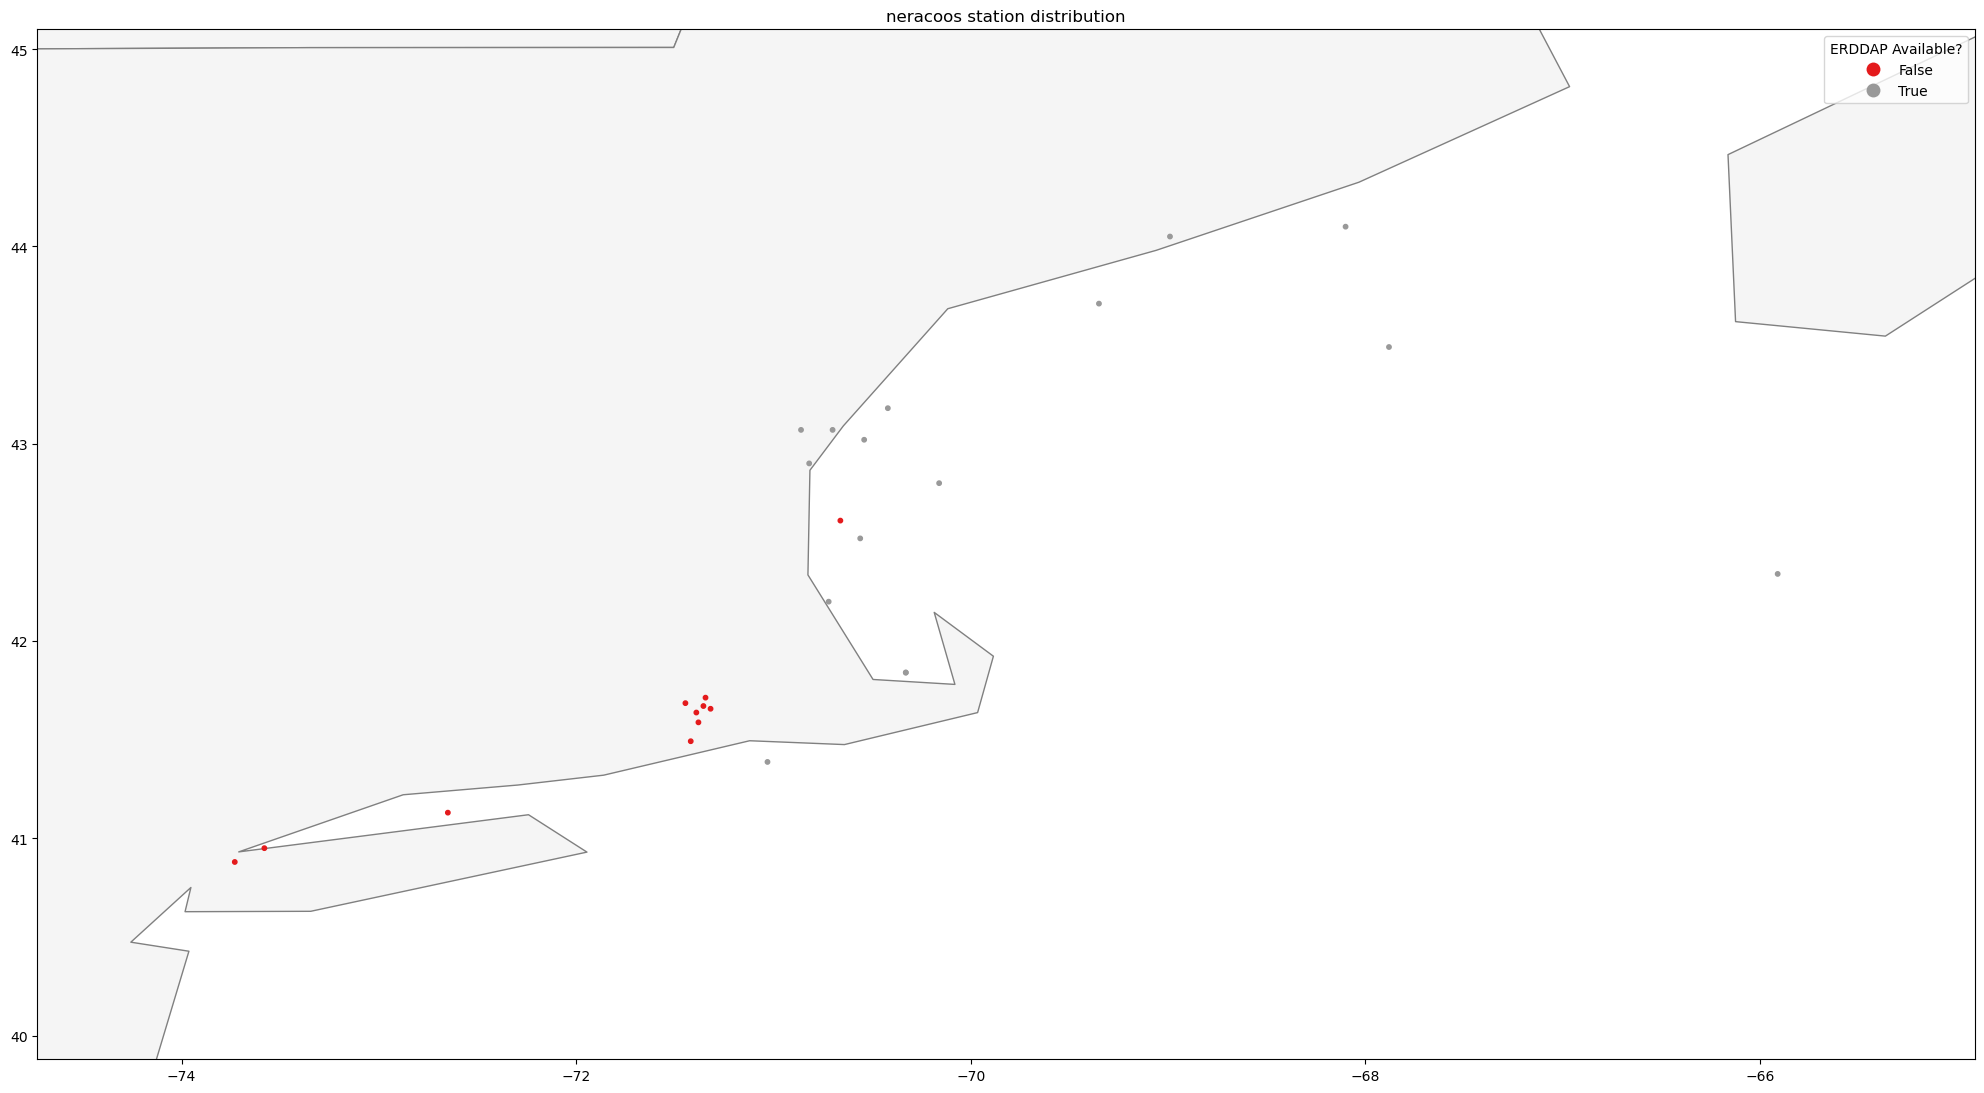

In [18]:
import geopandas
import matplotlib.pyplot as plt

#df = df.loc[df['']]

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='whitesmoke', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         column='erddap_avail', 
         categorical=True, 
         cmap = 'Set1',
         markersize=10, 
         legend=True,
         legend_kwds={'title': "ERDDAP Available?"},
         k=2,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)

plt.title('{} station distribution'.format(ra))

plt.show()

Make an interactive map.

When you click on a point the return is the information from the inventory.

In [19]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.loc[~gdf_final['geometry'].is_empty == True].drop(columns='Variable Names').explore('erddap_avail',cmap = 'Set1', style_kwds={"radius":5})


## Show me some bad coordinates

_if there are any_

In [20]:
gdf_final.loc[gdf_final['geometry'].is_empty == True]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_avail


In [21]:
# import urllib.request
# for url in gdf_final.loc[gdf_final['erddap_not_avail'],'Station Description'].str.replace('url: ',''):
#     print(url)
#     try:
#         urllib.request.urlopen(url).getcode()
#     except:
#         print("URL broken: %s" % url)
#         print(gdf_final.loc[gdf_final['Station Description'].str.contains(url,regex=False),'Station ID'])

# Show me the stations where ERDDAP doesn't exist or provide a valid response.

Reasons:
* Station not found on RA erddap
* dataset found but no data for this CY.

In [22]:
gdf_final.loc[~gdf_final['erddap_avail']]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_avail
3,NERACOOS,URI/GSO,NaN,Greenwich Bay,NBFSMN station,41.685,-71.446,fixed,6/1/2017 report to NERACOOS( 2003 historical),Y,NERACOOS (partial) URI/GSO (partial),Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.44600 41.68500),False
4,NERACOOS,URI/GSO,NaN,GSO Dock,NBFSMN station,41.492,-71.419,fixed,6/1/2017 report to NERACOOS( 1995 historical),Y,NERACOOS (partial) URI/GSO (partial),Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",NaN,POINT (-71.41900 41.49200),False
5,NERACOOS,URI/GSO,NaN,Conimicut Pt,NBFSMN station,41.7129,-71.34411667,moored_buoy,6/1/2019 report to NERACOOS( 2003 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.34412 41.71290),False
6,NERACOOS,URI/GSO,NaN,North Prudence,NBFSMN station,41.6704,-71.354716,moored_buoy,6/1/2019 report to NERACOOS( 2001 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.35472 41.67040),False
7,NERACOOS,URI/GSO,NaN,Poppasquash Pt,NBFSMN station,41.65655,-71.3185,moored_buoy,6/1/2019 report to NERACOOS( 2005 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.31850 41.65655),False
8,NERACOOS,URI/GSO,NaN,Mt View,NBFSMN station,41.637466,-71.390566,moored_buoy,6/1/2006 report to NERACOOS ( 2005 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.39057 41.63747),False
9,NERACOOS,URI/GSO,NaN,Quonset Pt,NBFSMN station,41.58761667,-71.38003333,moored_buoy,6/1/2006 report to NERACOOS ( 2005 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.38003 41.58762),False
21,NERACOOS,UCONN,44022,Execution Rocks,Moored buoy.,40.88,-73.73,moored_buoy,2004-09-01 00:00:00,Y,NERACOOS,Yp,University of Connecticut,academic,University of Connecticut,"University of Connecticut, Gulf of Maine Resea...","wind_speed, wind_to_direction, barometric_alti...",NaN,POINT (-73.73000 40.88000),False
22,NERACOOS,UCONN,44040,Western Long Island Sound,Moored buoy.,40.95,-73.58,moored_buoy,2001-08-01 00:00:00,Y,NERACOOS,Yp,University of Connecticut,academic,University of Connecticut,"University of Connecticut, Gulf of Maine Resea...","wind_speed, wind_to_direction, barometric_alti...",NaN,POINT (-73.58000 40.95000),False
23,NERACOOS,UCONN,44039,Central Long Island Sound,Moored buoy.,41.13,-72.65,moored_buoy,2002-02-01 00:00:00,Y,NERACOOS,Yp,University of Connecticut,academic,University of Connecticut,"University of Connecticut, Gulf of Maine Resea...","wind_speed, wind_to_direction, barometric_alti...",NaN,POINT (-72.65000 41.13000),False


# Do some checking against the IOOS catalog

only for datasets that we couldn't find in ERDDAP (per above)

In [23]:
from ckanapi import RemoteCKAN
import xarray as xr

problem_datasets = []

ua = 'ckanapiioos/1.0 (+https://ioos.us/)'

#ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua, get_only=True)
ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua)
ioos_catalog

gdf_ckan = gdf_final.loc[~gdf_final['erddap_avail']]

for station in gdf_ckan['Station ID'].dropna():

    RA = gdf_ckan.loc[gdf_ckan['Station ID']==station,'RA'].tolist()[0]
    
    print('Station "{}" + RA "{}"'.format(station.lower(), RA.lower()))
    
    # build RA tag query
    fq = '+organization:{}'.format(RA.lower())

    # build free text query
    q = "\""+station.lower()+"\""+" -glider"

    query = ioos_catalog.address + '/dataset/?' + 'q=' + q + '&organization=' + RA.lower()
    
    print('Query: {}'.format(query.replace(" ","%20")))

    datasets = ioos_catalog.action.package_search(q=q, fq=fq)

    

    if datasets['count'] > 0:
        print('\tfound {} dataset(s):'.format(datasets['count']))
        
        for dataset in datasets['results']:
            print('\t',dataset['title'])
            
            
            if dataset['resources']:
                print('\t',dataset['resources'][0]['url'])

                start_date = next(item for item in dataset["extras"] if item["key"] == "temporal-extent-begin")['value']
                end_date = next(item for item in dataset["extras"] if item["key"] == "temporal-extent-end")['value']

                print('\t','Coverage Meta:\n\t\t', start_date,' - ',end_date,'\n')

                if 'thredds' in dataset['resources'][0]['url']:
                    ds = xr.open_dataset(dataset['resources'][0]['url'])

                    time_max = ds.time.max().values

                    time_min = ds.time.min().values


                    print('\tCoverage Data:\n\t\t', time_min,' - ',time_max, '\n')

                    if pd.to_datetime(end_date) < pd.to_datetime(time_max, utc=True):
                        test_date = pd.to_datetime(time_max, utc=True)

                else:
                    test_date = pd.to_datetime(end_date, utc=True)

                if test_date > pd.to_datetime('{}-01-01'.format(cy), utc=True):
                    print('\t{} is valid.'.format(station))
                    break
                else:
                    print('\t{} is not valid.'.format(station))

                    problem_datasets.append(station)
            
            else:
                print('\t{} missing additional metadata'.format(station))
                problem_datasets.append(station)
    else:
        print("\tNo datasets found!")
        problem_datasets.append(station)

Station "uri/gso" + RA "neracoos"
Query: https://data.ioos.us/dataset/?q="uri/gso"%20-glider&organization=neracoos
	found 7 dataset(s):
	 URI GSO Pier, Surface Exo
	 http://www.neracoos.org/erddap/tabledap/URI_GSOPier_ExoTop
	 Coverage Meta:
		 2017-05-30T19:30:00Z  -  2020-10-07T15:30:00Z 

	URI/GSO is not valid.
	 URI Conimicut Point Surface Sonde
	 http://www.neracoos.org/erddap/tabledap/URI_CPoint_SurfaceSonde
	 Coverage Meta:
		 2019-07-16T08:00:00Z  -  2020-10-22T00:45:00Z 

	URI/GSO is not valid.
	 URI North Prudence  Bottom Sonde
	 http://www.neracoos.org/erddap/tabledap/URI_NP_BottomSonde
	 Coverage Meta:
		 2019-07-16T08:00:00Z  -  2020-11-02T20:45:00Z 

	URI/GSO is not valid.
	 URI Conimicut Point  Bottom Sonde
	 http://www.neracoos.org/erddap/tabledap/URI_CPoint_BottomSonde
	 Coverage Meta:
		 2019-07-18T04:45:00Z  -  2020-10-22T00:45:00Z 

	URI/GSO is not valid.
	 URI Poppasquash Point Bottom Sonde
	 http://www.neracoos.org/erddap/tabledap/URI_PP_BottomSonde
	 Coverage Met

StopIteration: 

Check the datasets that didn't have coverage in ERDDAP or through IOOS catalog and see if they are **Currently Operational?**

In [24]:
gdf_ckan.loc[gdf_ckan['Station ID'].isin(problem_datasets)]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_avail
3,NERACOOS,URI/GSO,NaN,Greenwich Bay,NBFSMN station,41.685,-71.446,fixed,6/1/2017 report to NERACOOS( 2003 historical),Y,NERACOOS (partial) URI/GSO (partial),Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.44600 41.68500),False
4,NERACOOS,URI/GSO,NaN,GSO Dock,NBFSMN station,41.492,-71.419,fixed,6/1/2017 report to NERACOOS( 1995 historical),Y,NERACOOS (partial) URI/GSO (partial),Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",NaN,POINT (-71.41900 41.49200),False
5,NERACOOS,URI/GSO,NaN,Conimicut Pt,NBFSMN station,41.7129,-71.34411667,moored_buoy,6/1/2019 report to NERACOOS( 2003 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.34412 41.71290),False
6,NERACOOS,URI/GSO,NaN,North Prudence,NBFSMN station,41.6704,-71.354716,moored_buoy,6/1/2019 report to NERACOOS( 2001 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.35472 41.67040),False
7,NERACOOS,URI/GSO,NaN,Poppasquash Pt,NBFSMN station,41.65655,-71.3185,moored_buoy,6/1/2019 report to NERACOOS( 2005 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.31850 41.65655),False
8,NERACOOS,URI/GSO,NaN,Mt View,NBFSMN station,41.637466,-71.390566,moored_buoy,6/1/2006 report to NERACOOS ( 2005 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.39057 41.63747),False
9,NERACOOS,URI/GSO,NaN,Quonset Pt,NBFSMN station,41.58761667,-71.38003333,moored_buoy,6/1/2006 report to NERACOOS ( 2005 historical),Y,RIDEM/URI/GSO,Yp,URI/GSO,gov_state,URI/GSO,RIDEM,"sea_water_temperature, sea_water_salinity, mo...",https://dem.ri.gov/environmental-protection-bu...,POINT (-71.38003 41.58762),False


Print out the available metadata from the IOOS Catalog for the last dataset.

In [ ]:
dataset

{'author': None,
 'author_email': None,
 'creator_user_id': '0ea3933c-4674-41dd-a17d-bfbc8c99bd75',
 'id': '2d3b8bab-0cc1-4a2c-a70d-9f2fcfae7989',
 'isopen': False,
 'license_id': None,
 'license_title': None,
 'maintainer': None,
 'maintainer_email': None,
 'metadata_created': '2025-01-09T12:46:53.170617',
 'metadata_modified': '2025-01-09T12:46:53.170633',
 'name': 'mapco2-buoy-maihi-bay-hawaii-island-hawaii',
 'notes': "This buoy is located in Maihi Bay approximately 200 meters offshore of the west coast of Hawaii Island just south of Kahaluu-Keauhou in the State of Hawaii. It is moored in waters 15 m (50 ft) deep. Data are recorded every 3 hours and transmitted daily. This Moored Autonomous Partial Pressure of Carbon Dioxide (MAPCO2) buoy was primarily established to monitor ocean acidification within a tropical coral reef ecosystem in the Central Pacific, complementing a national array of moored carbon dioxide buoys across the Pacific, Atlantic, and Caribbean. Other important phys

In [ ]:
# GLOS special case as they provide ERDDAP ID

# for dataset in gdf_final.loc[(~gdf_final['erddap_avail'] & ~gdf_final['Dataset (ERDDAP) ID'].isna()),'Dataset (ERDDAP) ID'].tolist():
#     print(dataset)
#     e.dataset_id = dataset
    
#     e.constraints = {
#                  "time>=": "{}-01-01".format(cy)
#             }
        
#     e.variables = ['time']
    
#     try:
        
#         df_data = e.to_pandas(parse_dates=True)
        
#         string = '\tDate range: {} - {}'.format(df_data.min()[0],df_data.max()[0])
        
#         print(string)
        
#         if pd.to_datetime(df_data.max()[0], utc=True) > pd.to_datetime('{}-01-01'.format(cy), utc=True):
            
#             datasetid = gdf_final.loc[gdf_final['Dataset (ERDDAP) ID']==dataset,'Station ID'].tolist()[0]
            
#             problem_datasets.remove(datasetid)
        
#     except:
#         print('\tNo valid data')

In [ ]:
#gdf_ckan.loc[gdf_ckan['Station ID'].isin(problem_datasets)]